In [8]:
import matplotlib.pyplot as plt

%matplotlib inline

import logging

import pandas as pd
import numpy as np
import networkx as nx

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import numpy as np
from gensim.models import Word2Vec, KeyedVectors
from datetime import datetime, date, time, timedelta
from itertools import *
import time
from pathlib import Path
import pickle
from scipy.spatial.distance import cosine

## Чтение графа

In [4]:
np.random.seed(0)

In [12]:
df = pd.read_csv('clicks_hashed.csv')
df.head()

,id,Click time,Ad id,Advertiser id,Site id,User id,User IP
0,0,1406977042,a3fbcd7e4b6362c75ab56687116a2433,510885b9a863ce0bd84b2ed3e58398f9,f9f32862920f6ca00c9725eade88f3d9,36b51acc9d3250851d0c0114aa04cc46,b1c7ac8696898d6f799e2f64c94156e6
1,1,1406977012,8683b0a8e3b4cac34cb40821e498ccdc,78ee95b2e2a854b40c714656b3f4321f,aa8e410642c0a8b95c53ea98a45c90b2,c6b363b3302908d1d6046d080df839e4,fd5cc76d2bfe24099c8777d557524b45
2,2,1406976966,8f8670b832c00cfd8493bca779aba942,e4551b0407c1cd88b24d367fc1ba4c5a,67877aff2349aa3053210af23632428f,0f2918a022fde0225b535988734461c4,39db42ae552c7c52dff1eb45d097bcab
3,3,1406976910,3437653362b4fab85ca9e147230208c5,478fb38eaeca30e36e1394411b2282a2,67877aff2349aa3053210af23632428f,bc605147700345892e6307ddfb4dedb6,10aa7a94cd916c9c6c1fa8c4cf22c92d
4,4,1406976857,a7e94defddbea68fb8cbc0885829a8b2,fcf373d8127ff67ac5501de0f6f80ec3,d2373599997dca05b50ade27578b8251,c32870919f9270d120cd58d68a957c18,0b0cad9116bb30d043be878866accd40


In [13]:
timestamp = df['Click time']
max_gap = max(timestamp) - min(timestamp)
d = timedelta(seconds=max_gap)
d.days, d.seconds

(3, 50272)

In [14]:
min_time, max_time = min(df['Click time']), max(df['Click time'])

In [7]:
nx_graph = nx.MultiGraph()
n_cols = len(df.columns)
user_col = df.columns[-2]
site_col = df.columns[-3]

graph = {}

for row in df.itertuples():
    vals_with_col_names = ['{}_{}'.format(df.columns[i], row[i + 1]) for i in range(len(df.columns))]
    time = row[2]
    user = vals_with_col_names[5]
    advertiser = vals_with_col_names[3]
    site = vals_with_col_names[4]
    for i in range(4, 6):
        nx_graph.add_node(vals_with_col_names[i], label=df.columns[i])

    nx_graph.add_edge(user, site, time=time)
    
    if user not in graph:
        graph[user] = []
    graph[user].append((site, time))
    if site not in graph:
        graph[site] = []
    graph[site].append((user, time))
    

for node in graph:
    graph[node].sort(key=lambda n: n[1])

## Генерация прогулок

In [15]:
def get_walks_simple(graph, length, walks_per_node, use_time=True):
    walks = []
    for node in graph.keys():
        for walk_number in range(walks_per_node):
            walk = [node]
            current_node = node
            
            avg_time = 0.0
            time = 0.0

            for i in range(length - 1):
                neighbours = graph[current_node]
                
                if use_time:
                    current_node, time = random_neighbour_by_time(neighbours, int(avg_time), intervals=[60, 3600, 86400, max_time])
                else:
                    random_ix = np.random.randint(0, high=len(neighbours))
                    current_node = neighbours[random_ix][0]

                avg_time = 0.8 * avg_time + 0.2 * time if len(walk) > 1 else time
                walk.append(current_node)

            walks.append(walk)
    return walks

In [16]:
def lower_bound(time, nodes):
    lo, hi = -1, len(nodes)
    while lo + 1 < hi:
        mid = (lo + hi) // 2
        mid_time = nodes[mid][1]
        if mid_time < time:
            lo = mid
        else:
            hi = mid
            
    assert hi in range(len(nodes) + 1)
    return hi

def upper_bound(time, nodes):
    # assuming time is int
    return lower_bound(time + 1, nodes)

In [17]:
# given timestamp and list of pairs (node, time) sorted by time return random node
# the closer node is by time, the more is probability
def random_neighbour_by_time(nodes, time, intervals):
    non_empty_intervals_bounds = []
    for i, interval in enumerate(intervals):
        prev_interval = 0 if i == 0 else intervals[i - 1]
        left = lower_bound(time - interval, nodes), upper_bound(time - prev_interval, nodes)
        right = lower_bound(time + prev_interval, nodes), upper_bound(time + interval, nodes)
        if left[1] > left[0] or right[1] > right[0]:
            non_empty_intervals_bounds.append((left, right))
            
            
    # sample vertices from next interval with probability twice lower than probability of current one
    assert len(non_empty_intervals_bounds) > 0, str(time) + ' ' + str(nodes[:10]) + ' ' + str(left) + ' ' + str(right)
    high = (1 << len(non_empty_intervals_bounds)) - 1
    rand_interval = np.random.randint(0, high=high) + 1
        
    cur = 1
    for i, (left, right) in enumerate(non_empty_intervals_bounds):
        if rand_interval <= cur:
            left_len = left[1] - left[0]
            right_len = right[1] - right[0]
            rand_ix_in_interval = np.random.randint(0, high=left_len + right_len)
            rand_ix_in_list = left[0] + rand_ix_in_interval if rand_ix_in_interval < left_len \
                                            else right[0] + rand_ix_in_interval - left_len
            return nodes[rand_ix_in_list]
        cur = 2 * cur + 1

## "Плохие" пользователи

In [11]:
def inc(dic, key, val):
    if key not in dic:
        dic[key] = []
    dic[key].append(val)

In [39]:
def tail_of_sorted(dic, num, rev=True):
    cur_tail = set()
    last_key = None
    for key in sorted(dic.keys(), reverse=rev):
        remainder = max(0, num - len(cur_tail))
        if remainder > 0:
            last_key = key
            cur_tail |= set(dic[key][:remainder])
        else:
            break
    return cur_tail, last_key

In [145]:
clicks_to_node, duplicates_to_node, gap_to_node = {}, {}, {}
for node in nx_graph.node:
    if node.startswith("User"):
        clicks = nx_graph.degree(node)
        inc(clicks_to_node, clicks, node)
        
        max_duplicates = 0
        node_gap = -1
        
        for neighbor in nx_graph.neighbors(node):
            edge_data = nx_graph.get_edge_data(node, neighbor)
            timestamps = [edge_data[neigh]['time'] for neigh in edge_data]
            node_gap = max(node_gap, max(timestamps) - min(timestamps))
            max_duplicates = max(max_duplicates, len(timestamps))
            
        inc(duplicates_to_node, max_duplicates, node)
        if node_gap >= 0 and clicks >= 10:
            inc(gap_to_node, node_gap, node)
        

In [139]:
clicks_tail, clicks = tail_of_sorted(clicks_to_node, 100)
duplicates_tail, _ = tail_of_sorted(duplicates_to_node, 100)

In [147]:
gaps_tail, _ = tail_of_sorted(gap_to_node, 100, rev=False)

In [148]:
max([nx_graph.degree(node) for node in gaps_tail])

22

In [150]:
len(gaps_tail & clicks_tail)

0

In [152]:
inner_mean_dist(list(gaps_tail))

/home/roman/.local/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.3014242861148986

In [155]:
mean_dist(clicks_tail, sampled_users)

/home/roman/.local/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.41072830001972616

In [74]:
inner_mean_dist(list(clicks_tail)), inner_mean_dist(list(duplicates_tail))

/home/roman/.local/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


(0.12671810384350593, 0.12071746685288169)

In [59]:
clicks_head, _ = tail_of_sorted(clicks_to_node, 100)

In [80]:
inner_mean_dist(list(gaps_tail)) 

/home/roman/.local/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.6790895263567059

In [69]:
inner_mean_dist(clicks_head)

NameError: name 'inner_mean_dist' is not defined

In [51]:
len(clicks_tail & gaps_tail), len(clicks_tail & duplicates_tail), len(duplicates_tail & gaps_tail)

(500, 452, 452)

In [110]:
site_degree = {}

for node in duplicates_tail:
    edge_multiplicities = [(site, len(nx_graph.get_edge_data(node, site))) \
                                          for site in nx_graph.neighbors(node)]
    for site, _ in edge_multiplicities:
        if site not in site_degree:
            site_degree[site] = 0
        site_degree[site] += 1
        
        

sorted_site_degree = sorted(list(site_degree.items()), key=lambda site2deg: site2deg[1], reverse=True)

In [111]:
duplicated_sites = [site for (site, deg) in sorted_site_degree if deg > 10]

In [112]:
duplicated_sites

['Site id_f9f32862920f6ca00c9725eade88f3d9',
 'Site id_e8a690ac5bd4e59193e80d938e157140']

In [ ]:
sites = np.asarray([n for n in nx_graph.nodes() if n.startswith('Site')])

In [ ]:
sampled_sites = np.random.choice(sites, size=200, replace=False)

In [ ]:
mean_dist(sampled_sites, duplicates_tail)

In [104]:
outliers = clicks_tail | duplicates_tail
len(outliers)

104

In [278]:
inner_mean_dist(list(outliers))

/home/roman/.local/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.4062107770680817

In [23]:
def mean_dist(xs, ys, vectors):
    sum_dist, cnt = 0, 0
    for user in xs:
        for site in ys:
            sum_dist, cnt = sum_dist + vectors.distance(user, site), cnt + 1

    return sum_dist / cnt

In [19]:
inner_mean_dist(sampled_sites), inner_mean_dist(duplicated_sites)

NameError: name 'inner_mean_dist' is not defined

In [76]:
users = [n for n in nx_graph.nodes() if n.startswith('User')]

sampled_users = np.random.choice(np.asarray(users), size=200, replace=False)
inner_mean_dist(sampled_users)

0.7273998153139025

In [62]:
def find_latest(folder):
    if Path(folder).exists():
        files = [f for f in Path(folder).iterdir()]
        if len(files) > 0:
            return folder + '/' + max(files, key=lambda f: f.name).name
        return None
    return None

In [61]:
def measure_time(fun, name='fun'):
    before = time.time()
    res = fun()
    print(name + ' took', time.time() - before, 's')
    return res

In [ ]:
latest_walks_file = 'saved/walks/with_time.pickle'

In [157]:
latest_walks_file = None

In [200]:
use_time = False
model_name = 'with_time' if use_time else 'without_time'

In [201]:
latest_vector_file = 'saved/embeddings/' + model_name

In [164]:
def get_name_or_timestamp():
    timestamp = datetime.isoformat(datetime.now(), timespec='seconds')
    return model_name if model_name is not None else datetime.isoformat(datetime.now(), timespec='seconds')

In [165]:
def compute_embeddings(walks):
    model = measure_time(lambda: Word2Vec(walks, size=20, window=3, min_count=0, sg=1, workers=2, iter=1), 'word2vec')
    model.wv.save('saved/embeddings/' + get_name_or_timestamp())
    return model.wv

In [202]:
if latest_vector_file is not None:
    print('reading saved embeddings from', latest_vector_file)
    word_vectors = KeyedVectors.load(latest_vector_file, mmap='r')
elif latest_walks_file is not None:
    print('computing embeddings from saved walks')
    with open(latest_walks_file, 'rb') as f:
        walks = pickle.load(f)
    word_vectors = compute_embeddings(walks)
else:
    print('computing walks and embeddings')
    walks = measure_time(lambda: get_walks_simple(graph, length=10, walks_per_node=3, use_time=use_time), 'walks')
    print('number of walks', len(walks))
    with open('saved/walks/' + get_name_or_timestamp() + '.pickle', 'wb') as f:
        pickle.dump(walks, f)
    word_vectors = compute_embeddings(walks)

len(word_vectors.index2word)

reading saved embeddings from saved/embeddings/without_time


399260

In [190]:
with open('saved/walks/with_time.pickle', 'rb') as f:
    walks1 = pickle.load(f)
with open('saved/walks/without_time.pickle', 'rb') as f:
    walks2 = pickle.load(f)
    
print(walks1[0], walks2[0])

['User id_36b51acc9d3250851d0c0114aa04cc46', 'Site id_f9f32862920f6ca00c9725eade88f3d9', 'User id_a531ba5616a52555a516455878e7dfe6', 'Site id_f9f32862920f6ca00c9725eade88f3d9', 'User id_556ef402bfc0f6fb780feb2a103cd18f', 'Site id_f9f32862920f6ca00c9725eade88f3d9', 'User id_319da330cd02b809a73d91a8382dd26b', 'Site id_f9f32862920f6ca00c9725eade88f3d9', 'User id_4c5f09f72cfee93525dd5f6cdc065b92', 'Site id_f9f32862920f6ca00c9725eade88f3d9'] ['User id_36b51acc9d3250851d0c0114aa04cc46', 'Site id_f9f32862920f6ca00c9725eade88f3d9', 'User id_ecf67047ee586e82a1e3467fc168bf45', 'Site id_f9f32862920f6ca00c9725eade88f3d9', 'User id_28986291a8ceb9127455cc1f3ee0029f', 'Site id_f9f32862920f6ca00c9725eade88f3d9', 'User id_dba6ac5c252a4d79fe816aed6c2b2e62', 'Site id_f9f32862920f6ca00c9725eade88f3d9', 'User id_7ca91fc22a263d8200a07dd630d8420f', 'Site id_f9f32862920f6ca00c9725eade88f3d9']


In [90]:
node2vec = [(n, word_vectors[n]) for n in word_vectors.index2word if n.startswith('User')]

In [39]:
print(len(node2vec))
outlier_node2vec, inlier_node2vec = [], []
for node, emb in node2vec:
    if node in outliers:
        outlier_node2vec.append((node, emb))
    else:
        inlier_node2vec.append((node, emb))

398276


In [40]:
outlier_embeddings = [node2emb[1] for node2emb in outlier_node2vec]
inlier_embeddings = [node2emb[1] for node2emb in inlier_node2vec]

In [41]:
np.random.shuffle(inlier_embeddings)
selected_inlier_embeddings = inlier_embeddings[:500]

In [196]:
duplicates_walks = [w for w in walks if w[0] in duplicates_tail]

NameError: name 'walks' is not defined

In [32]:
def embed_svd(visualize_vecs):
    temp = (visualize_vecs - np.mean(visualize_vecs, axis=0))
    covariance = 1.0 / visualize_vecs.shape[0] * temp.T.dot(temp)
    U, S, V = np.linalg.svd(covariance)
    return temp.dot(U[:, 0:2])

def embed_tsne(visualize_vecs):
    tsne = TSNE(random_state=42)
    return tsne.fit_transform(visualize_vecs)

def embed_tsne_cosine(visualize_vecs):
    tsne = TSNE(random_state=42, metric='cosine')
    return tsne.fit_transform(visualize_vecs)

def embed_id(visualize_vecs):
    return visualize_vecs

In [33]:
def visualize(nodes_with_colors, vectors, ax, embed_to_2d=embed_tsne):
    visualize_vecs = np.asarray([vectors[n] for (nodes_group, _, _) in nodes_with_colors for n in nodes_group])
    
    coord = embed_to_2d(visualize_vecs)

    offset = 0
    for nodes_group, color, annotate in nodes_with_colors:
        new_offset = offset + len(nodes_group)
        ax.scatter(coord[offset:new_offset, 0], coord[offset:new_offset, 1], color=color, alpha=0.4)
        if annotate:
            for i, node in enumerate(nodes_group):
                label = node[:node.find(' ')]
                ax.annotate(label, coord[offset + i])
        offset = new_offset

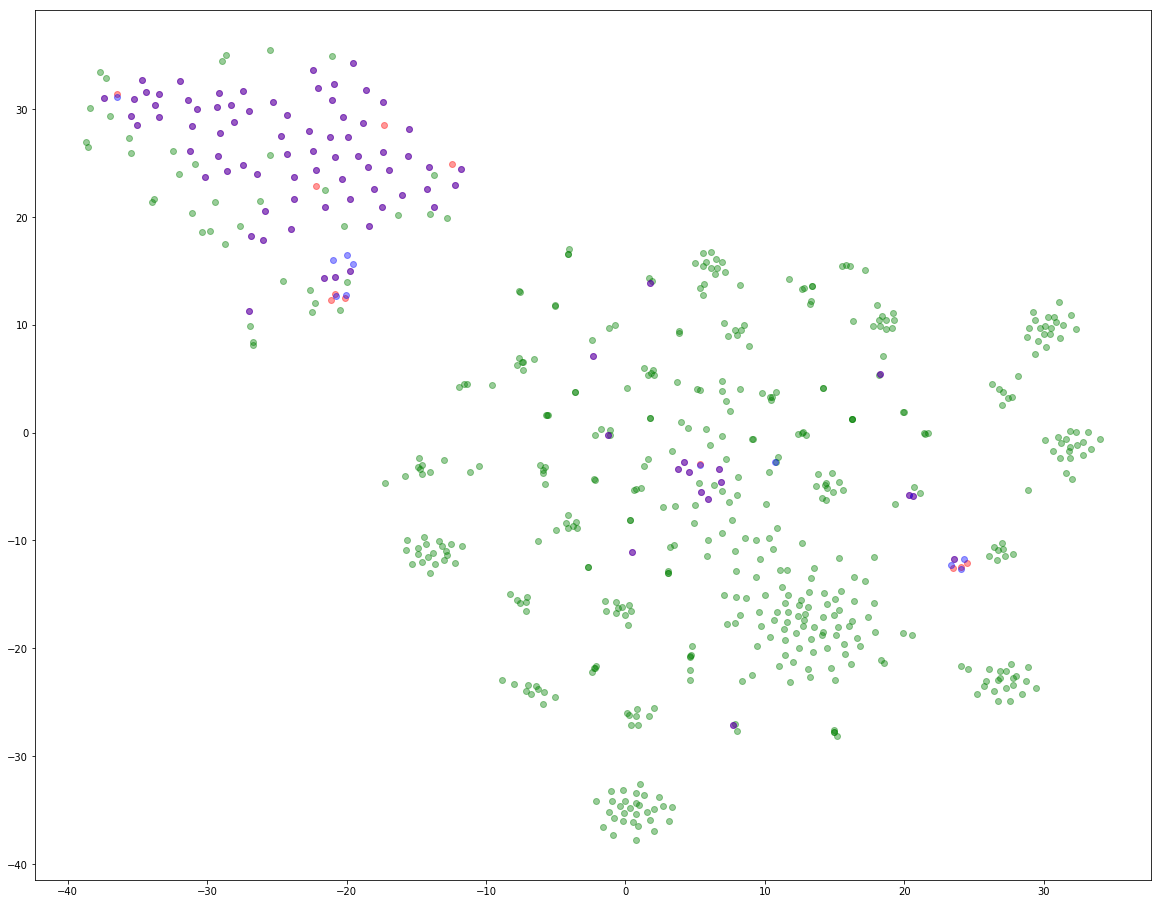

In [136]:
fig = plt.figure(figsize=(20,16))
ax = fig.gca()

inliers = np.random.choice(np.asarray([n for n in nx_graph.nodes() if n not in outliers]), size=500, replace=False)
nodes_with_colors = [
    (inliers, 'green', False), 
    (duplicates_tail, 'red', False),
    (clicks_tail, 'blue', False)
#     ,
#     (clicks_tail - duplicates_tail - gaps_tail, 'orange', False),
#     (duplicated_sites, 'black', True)
]
visualize(nodes_with_colors, word_vectors, ax, embed_to_2d=embed_tsne_cosine)

In [137]:
fig.savefig('without_time_tsne.png', pad_inches=0, bbox_inches='tight')

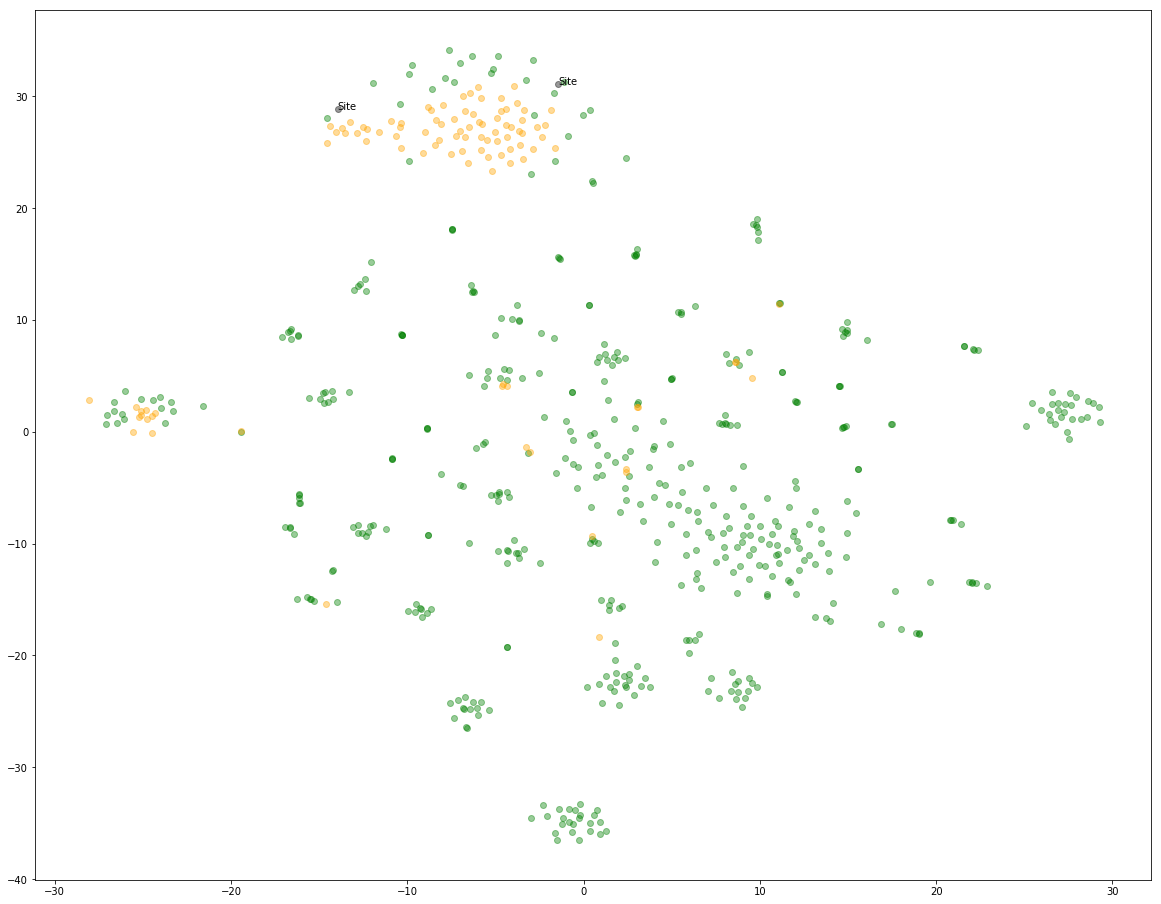

In [206]:
fig = plt.figure(figsize=(20,16))
ax = fig.gca()

inliers = np.random.choice(np.asarray([n for n in nx_graph.nodes() if n not in outliers]), size=500, replace=False)
nodes_with_colors = [
    (inliers, 'green', False), 
    (gaps_tail, 'orange', False),
    (duplicated_sites, 'black', True)
]
visualize(nodes_with_colors, word_vectors, ax, embed_to_2d=embed_tsne_cosine)

In [205]:
inner_mean_dist(gaps_tail, word_vectors), inner_mean_dist(sampled_users, word_vectors), mean_dist(sampled_users, gaps_tail, word_vectors)

(0.18101034974811053, 0.4411486683840613, 0.3797146758701652)

In [ ]:
(0.18312082339416852, 0.45549217343594217, 0.39602265734663233)

In [331]:
def visualize_all_means(nodes_with_colors, vectors):
    for embed_to_2d, title in [(embed_tsne, 'tsne'), (embed_tsne_cosine, 'tsne_cos'), (embed_svd, 'svd')]:
        fig = plt.figure(figsize=(20, 16))
        ax = fig.gca()
        ax.set_title(title)
        visualize(nodes_with_colors, vectors, ax, embed_to_2d=embed_to_2d)

In [238]:
popular_site = duplicated_sites[0]
similar_nodes = word_vectors.similar_by_word(popular_site, topn=100)
for neighbor, dist in similar_nodes:
    print(nx_graph.get_edge_data(neighbor, popular_site))
set(similar_nodes) & duplicates_tail

{0: {'time': 1406807790}}
{0: {'time': 1406707874}, 1: {'time': 1406707842}, 2: {'time': 1406707803}, 3: {'time': 1406707667}, 4: {'time': 1406707474}, 5: {'time': 1406707339}, 6: {'time': 1406707142}}
{0: {'time': 1406840866}, 1: {'time': 1406837400}}
{0: {'time': 1406900057}}
{0: {'time': 1406809133}, 1: {'time': 1406809064}, 2: {'time': 1406808954}}
{0: {'time': 1406916747}, 1: {'time': 1406746554}, 2: {'time': 1406746316}, 3: {'time': 1406711524}, 4: {'time': 1406711455}}
{0: {'time': 1406702980}, 1: {'time': 1406702887}}
{0: {'time': 1406883145}, 1: {'time': 1406882937}, 2: {'time': 1406882728}, 3: {'time': 1406882471}, 4: {'time': 1406882288}}
{0: {'time': 1406786938}, 1: {'time': 1406786285}, 2: {'time': 1406786236}, 3: {'time': 1406786176}, 4: {'time': 1406786128}, 5: {'time': 1406786079}}
{0: {'time': 1406836270}, 1: {'time': 1406835697}, 2: {'time': 1406834625}, 3: {'time': 1406711383}, 4: {'time': 1406711202}, 5: {'time': 1406709862}, 6: {'time': 1406709688}}
{0: {'time': 14

/home/roman/.local/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


set()

In [272]:
bad_walks = [w for w in walks if w[1] == w[3]]
len(bad_walks)

1117249

In [275]:
[w for w in walks if w[1] != w[3]][:5]

[['Site id_f9f32862920f6ca00c9725eade88f3d9',
  'User id_dcb61b09751fa0c18cac3991a5bb9037',
  'Site id_f9f32862920f6ca00c9725eade88f3d9',
  'User id_e435874a9baed3fc13ad6f3a62559901',
  'Site id_0a60a828d5dcc4fa861d2ec45f89c184'],
 ['Site id_f9f32862920f6ca00c9725eade88f3d9',
  'User id_a8e839e8f6d0f45622e8f9b4069b78d3',
  'Site id_f9f32862920f6ca00c9725eade88f3d9',
  'User id_a5442479932b71f344ae71f9b7990fd9',
  'Site id_f9f32862920f6ca00c9725eade88f3d9'],
 ['Site id_f9f32862920f6ca00c9725eade88f3d9',
  'User id_21024d384cd8fc0272b7127f418fe5f0',
  'Site id_f9f32862920f6ca00c9725eade88f3d9',
  'User id_3807fb6944f6e8cba5b231e2b2945c46',
  'Site id_f9f32862920f6ca00c9725eade88f3d9'],
 ['Site id_aa8e410642c0a8b95c53ea98a45c90b2',
  'User id_579730a84c5bfc6203764950d66dd0ae',
  'Site id_aa8e410642c0a8b95c53ea98a45c90b2',
  'User id_961072f5791a3cb579525c792f6a223f',
  'Site id_aa8e410642c0a8b95c53ea98a45c90b2'],
 ['Site id_aa8e410642c0a8b95c53ea98a45c90b2',
  'User id_e7ce4ded3c908ca4a1f

In [268]:
multiplicities = [len(nx_graph.get_edge_data(popular_site, n)) for n, _ in similar_nodes \
                             if nx_graph.get_edge_data(popular_site, n) is not None]
min(multiplicities), max(multiplicities)

(1, 21)

In [258]:
tsne = TSNE(random_state=42)
nodes = [popular_site] + [n for n in nx_graph.neighbors(popular_site) if len(nx_graph.get_edge_data(popular_site, n)) >= 50]

In [259]:
len(nodes)

30

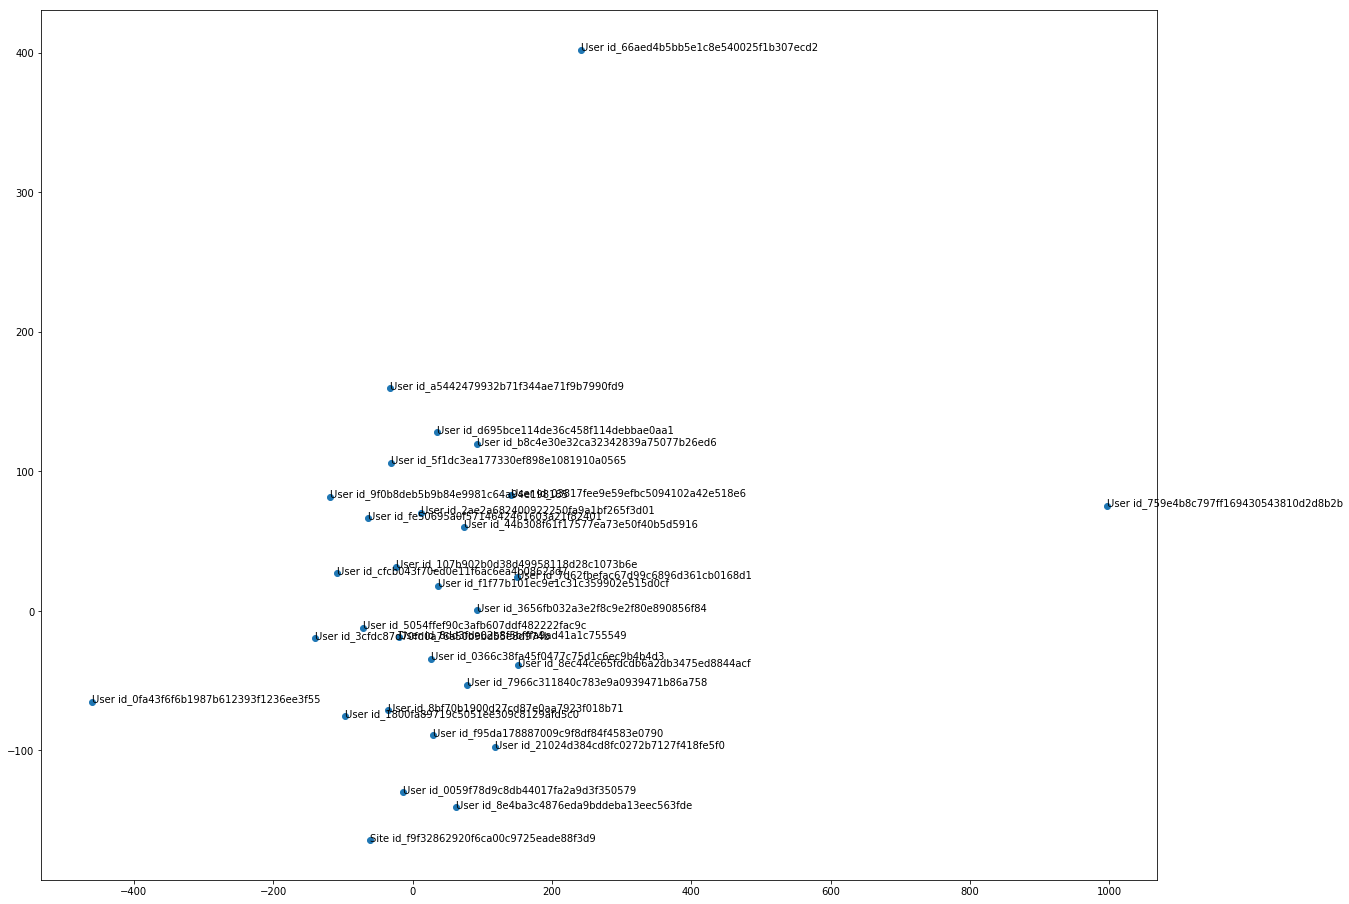

In [262]:
plt.figure(figsize=(20,16))
node_vectors = [word_vectors[n] for n in nodes]
coords = tsne.fit_transform(node_vectors)
plt.scatter(coords[:, 0], coords[:, 1])
for i, node in enumerate(nodes):
    plt.annotate(node, coords[i])

In [237]:
similar_nodes

[('User id_df9d602b1271772beeeba8ec5873eb1e', 0.9932206869125366),
 ('User id_3034f50ffcfb0baf761fbb71c9658775', 0.9867873787879944),
 ('User id_1268b03f0aa2f134dc921044c19a9000', 0.9852049946784973),
 ('User id_fa8bdece29d60fb62176de944a70d795', 0.9850931167602539),
 ('User id_c6e9efdca2b133f080238185d054629e', 0.9822958707809448),
 ('User id_c471d1e84b19cbe875c4a67a1966ebaa', 0.9818623065948486),
 ('User id_7eb82312a371d16f7b626f6ad062e54e', 0.9814335703849792),
 ('User id_8742b401ecf598d8cc63ed089d94226a', 0.9813147783279419),
 ('User id_e41eeb4b31f565865eeb8db9084e952d', 0.9809294939041138),
 ('User id_721f1b04e2ef325c8568d66c18a07189', 0.9802324771881104)]

In [22]:
def inner_mean_dist(points, vectors):
    points = list(points)
    sum_dist = 0
    cnt = 0
    for i in range(len(points)):
        for j in range(i):
            cnt += 1
            sum_dist += vectors.distance(points[i], points[j])
            
    return sum_dist / cnt

In [37]:
inner_mean_dist(duplicates_tail), inner_mean_dist(clicks_tail)

NameError: name 'duplicates_tail' is not defined

In [108]:
np.apply_along_axis(norm, 1, word_vectors.vectors).mean()

0.29131055

In [100]:
fig.savefig("embeddings_tsne_euclidean.png")

In [35]:
from scipy.spatial import KDTree

def find_max_avg_dist(embeddings, node2vec):
    tree = KDTree(embeddings)
    avg_dists = []
    for i, (node, embedding) in enumerate(node2vec):
        neighbor_dists, _ = tree.query([embedding], k=5)
        avg_dists.append((node, neighbor_dists[0][1:].mean()))

    avg_dists.sort(key=lambda p: p[1])
    print(avg_dists[:20])

In [74]:
import time
# measure_time(lambda: find_max_avg_dist(word_vectors.vectors, node_embeddings))
measure_time(lambda: find_max_avg_dist(outlier_embeddings, outlier_node2vec))

[('User id_219a76994902b81f94f7722bd9e3624a', 0.12268597312819893), ('User id_42ec4348eab39087f29f8d428a9650d1', 0.12293063450903086), ('User id_9c19a29d2d8f8cea0dc67390122eb5b7', 0.12523837919290146), ('User id_a139a833ee59971130a0d0e261c85f22', 0.12719131467873562), ('User id_f481c8b128b82f424860a8dbd9e14c16', 0.12925896950830765), ('User id_5a632d66f16ed81c8f3cf417158b981d', 0.13022413122587206), ('User id_010b4db9e990dd95e3c9c3f9f7e68bd6', 0.13205763471651288), ('User id_8e85225b64350fa9dc4463b345f3d713', 0.1335517338371278), ('User id_1280f49b231b39a61b5e88f03ce00eb2', 0.13535171838799145), ('User id_e4b1a41ad5392fb0e8f5bd0d811a42ac', 0.1366942129738079), ('User id_ae11e8c25a0fe2ad88343e3d6a1799ed', 0.1429104691420896), ('User id_0bdc9da791f89692e2302ac3595250f3', 0.14358437931176743), ('User id_05b63c032c7b3f1e3e1bcd4b5e91c223', 0.14466283816939332), ('User id_36e38bc276341d6fec7bea4d7766c13e', 0.1464355881024823), ('User id_bfe90055895c0193903ffe9f304c3043', 0.14696251577605376)

In [86]:
k = 5
def find_max_kth_dist():
    dists = []
    for i, (node, embedding) in enumerate(node2vec):
        if i > 0 and i % 100 == 0:
            print(i)
        neighbor_dists = word_vectors.distances(node, [])
        kth_neighbour = np.partition(neighbor_dists, k)[:k - 1].max()
        dists.append(kth_neighbour)

    dists.sort(key=lambda p: p[1])
    print(avg_dists[:20])
    return dists

In [84]:
measure_time(lambda: find_max_kth_dist())

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200


KeyboardInterrupt: 

In [99]:
w1 = word_vectors.index2word[0]
w2 = word_vectors.index2word[1]

word_vectors.vectors[0].dot(word_vectors.vectors[1]) / norm(word_vectors.vectors[1]) / norm(word_vectors.vectors[0]), word_vectors.similarity(w1, w2)

/home/roman/.local/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


(0.3818835, 0.3818835)

In [97]:
def norm(x):
    return np.sqrt(x.dot(x))

In [3]:
# convert to format used for walks generation: dict u -> [(v, time)]
def from_nx_graph(graph):
    adj_dict = {}
    
    def add_neighbor(u, v, time):
        if u not in adj_dict:
            adj_dict[u] = []
        adj_dict[u].append((v, time))

    def add_edge(u, v, time):
        add_neighbor(u, v, time)
        add_neighbor(v, u, time)

    for u, v, edge_data in graph.edges(data=True):
        add_edge(str(u), str(v), edge_data.get('time', 0))
        
    return adj_dict
        

In [4]:
from networkx.generators.classic import complete_graph, complete_multipartite_graph

In [5]:
part_size = 50
bipartite = from_nx_graph(complete_multipartite_graph(part_size, part_size))

In [6]:
part_a = [str(i) for i in range(part_size)]
part_b = [str(i) for i in range(part_size, 2 * part_size)]

In [151]:
def get_embeddings_with_params(params):
    bipartite_walks = get_walks_simple(bipartite, length=params.get('length', 10), walks_per_node=params.get('walks_per_node', 50), use_time=False)
    return bipartite_walks, Word2Vec(bipartite_walks, size=128, window=params.get('window', 2))

In [154]:
def tweak_param(param, values, common):
    inner_dists_a = []
    inner_dists_b = []
    inner_dists_ab = []
    outer_dists = []
    diffs = []
    
    for v in values:
        common[param] = v
        bipartite_walks, bipartite_model = get_embeddings_with_params(common)
        inner_dists_a.append(inner_mean_dist(part_a, bipartite_model.wv))
        inner_dists_b.append(inner_mean_dist(part_b, bipartite_model.wv))
        inner_dists_ab.append(inner_mean_dist(part_a + part_b, bipartite_model.wv))
        outer_dists.append(mean_dist(part_a, part_b, bipartite_model.wv))
        diffs.append(get_part_differences(bipartite_walks, common.get('window', 2)))
    
    print(diffs)
    quotient = [(x + y) / 2 / z for x, y, z in zip(inner_dists_a, inner_dists_b, outer_dists)]

    fig = plt.figure()
    axes = fig.subplots(5, 1, sharex=True)
    
    axes[0].plot(values, inner_dists_a, label='inner_a')
    axes[0].plot(values, inner_dists_b, label='inner_b')
    axes[1].plot(values, inner_dists_ab, label='inner_all')
    axes[2].plot(values, outer_dists, label='outer')
    axes[3].plot(values, quotient, label='quotient')
    axes[4].plot(values, diffs, label='diff')
    for ax in axes:
        ax.legend()

/home/roman/.local/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


100.0
51.351647409628654
66.66674105184428
51.428508687448776
59.99978950524719
51.5150631549523
[1.0, 0.5135164740962865, 0.6666674105184428, 0.5142850868744877, 0.5999978950524719, 0.515150631549523]


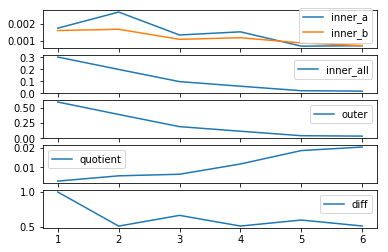

In [155]:
tweak_param('window', list(range(1, 7)), {'length': 20})

/home/roman/.local/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


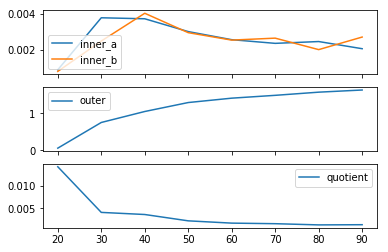

In [122]:
tweak_param('length', list(range(20, 100, 10)), {'window': 5})

In [97]:
bipartite_walks = get_walks_simple(bipartite, length=200, walks_per_node=50, use_time=False)
bipartite_model = Word2Vec(bipartite_walks, window=4, size=12)

.5 * (inner_mean_dist(part_a, bipartite_model.wv) + inner_mean_dist(part_b, bipartite_model.wv)) / mean_dist(part_a, part_b, bipartite_model.wv)

0.018425861442528585

In [96]:
bipartite_walks = get_walks_simple(bipartite, length=20, walks_per_node=50, use_time=False)
bipartite_model = Word2Vec(bipartite_walks, window=2, size=12)

.5 * (inner_mean_dist(part_a, bipartite_model.wv) + inner_mean_dist(part_b, bipartite_model.wv)) / mean_dist(part_a, part_b, bipartite_model.wv)

/home/roman/.local/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.00798089031218898

In [148]:
def get_part_differences(bipartite_walks, window):
    diffs = []
    part_cnts = [[0, 0] for k in range(2 * part_size)]
    for w in bipartite_walks:
        for i in range(len(w)):
            for j in range(-window, window + 1):
                if j != 0 and i + j < len(w) and i + j >= 0:
                    part_cnts[int(w[i])][int(w[i + j]) // part_size] += 1
    mean_diff = 0
    for i in range(part_size):
        for p in range(2):
            index = i + p * part_size
            mean_diff += part_cnts[index][1 - p] / (part_cnts[index][0] + part_cnts[index][1])
    print(mean_diff)
    return mean_diff / 2 / part_size

ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

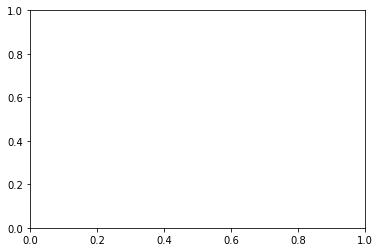

In [125]:
ax = plt.figure().gca()
ax.plot(ws, diffs)

In [73]:
cnt = 0
for w in bipartite_walks:
    n_entries = sum([int(u == '0') for u in w])
    n_part_a = sum([int(int(u) >= part_size) for u in w])
    
#     print(n_entries, n_part_a)
    cnt += (n_part_a) * n_entries
    
cnt

2760

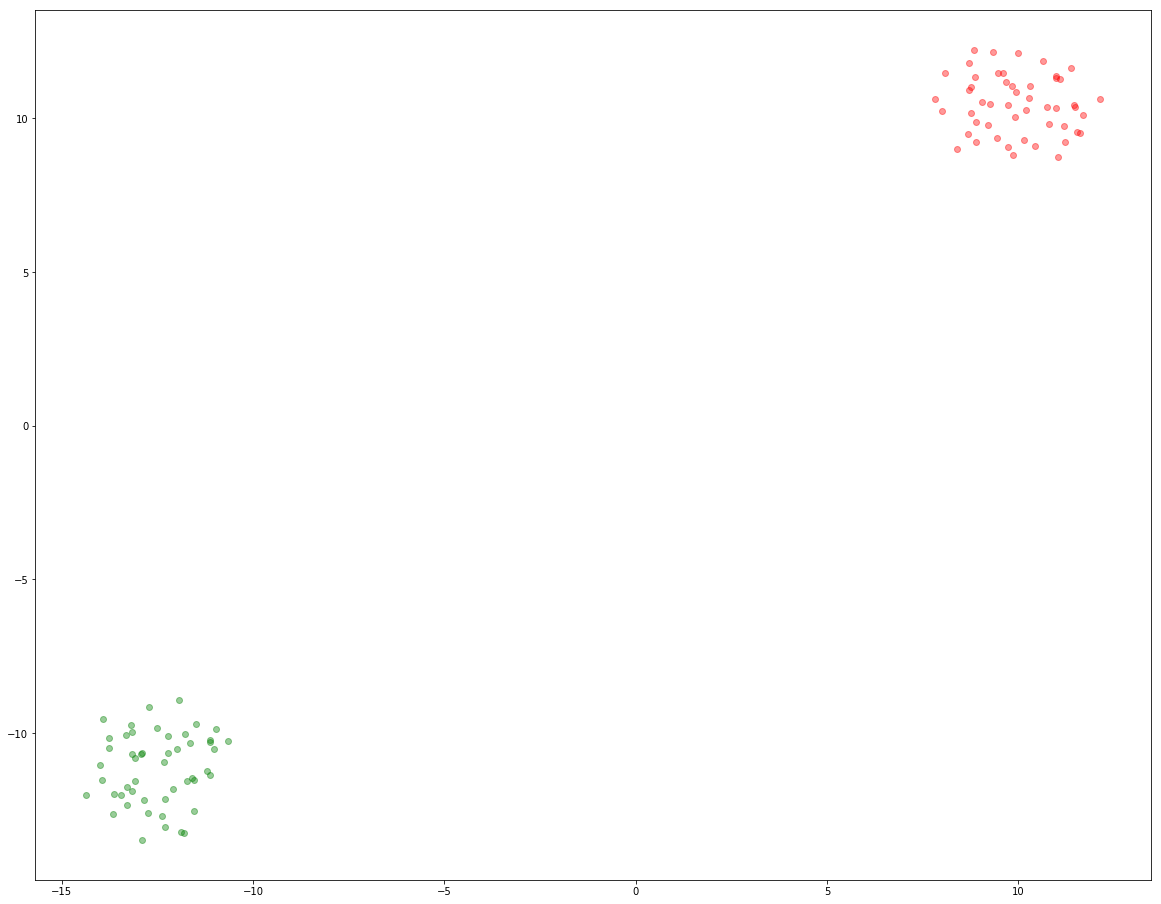

In [90]:
visualize([(part_a, 'red', False), (part_b, 'green', False)], bipartite_model.wv, plt.figure(figsize=(20, 16)).gca(), embed_to_2d=embed_tsne_cosine)

In [8]:
part_size = 100
nx_tripartite = complete_multipartite_graph(part_size, part_size, part_size)

In [261]:
for u in range(part_size):
    for v in range(part_size * 2, part_size * 3):
        nx_tripartite.remove_edge(u, v)

In [262]:
nx_tripartite.number_of_edges(), nx_tripartite.number_of_nodes()

(20000, 300)

In [13]:
def get_embeddings(graph):
    walks = get_walks_simple(from_nx_graph(graph), length=5, walks_per_node=10, use_time=False)
    model = Word2Vec(walks, size=12)
    return walks, model.wv, model

In [16]:
walks, vectors, model = get_embeddings(nx_tripartite)

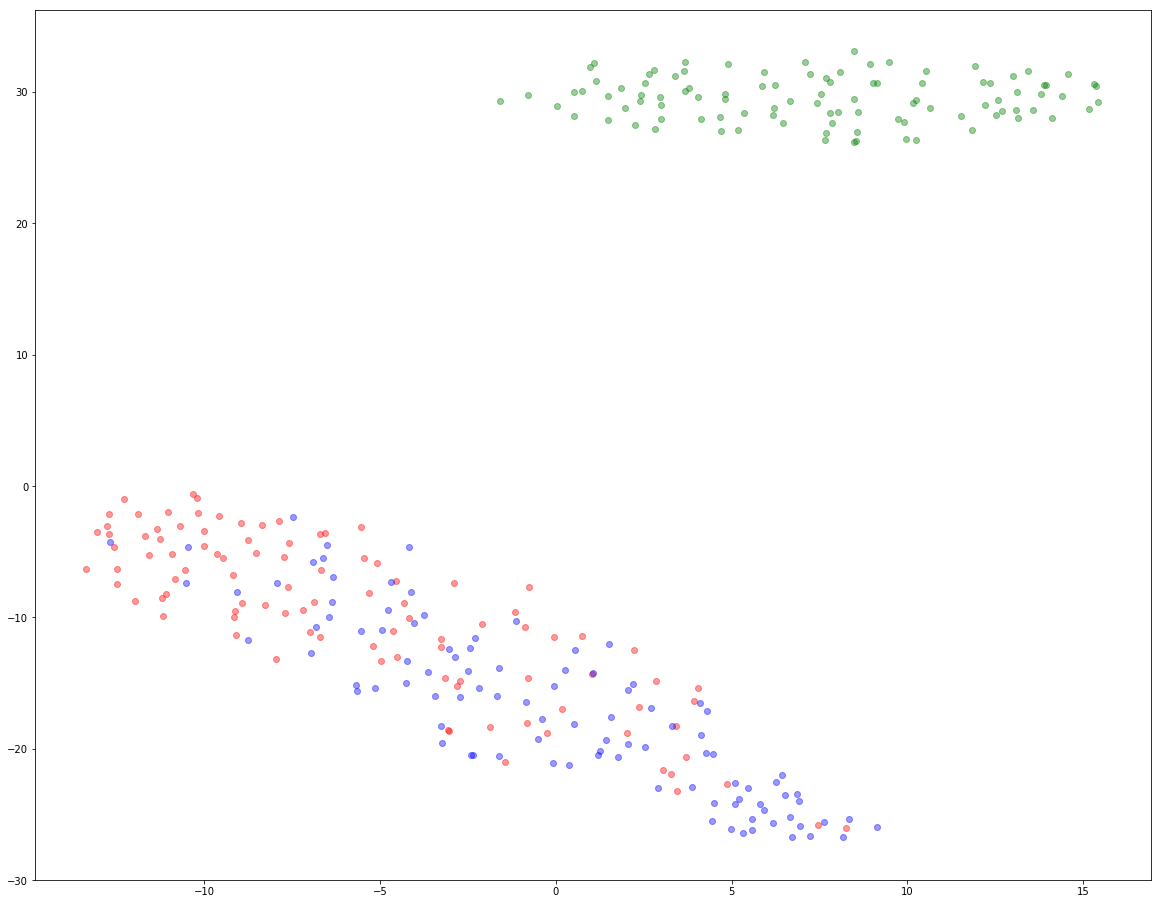

In [270]:
part_a = [str(i) for i in range(part_size)]
part_b = [str(i) for i in range(part_size, part_size * 2)]
part_c = [str(i) for i in range(part_size * 2, part_size * 3)]

visualize([(part_a, 'red', False), (part_b, 'green', False), (part_c, 'blue', False)], vectors, ax=plt.figure(figsize=(20, 16)).gca())

In [273]:
cnts = [0, 0, 0]
for w in walks:
    if w[0] == str(part_size):
        for i in range(len(w)):
            cnts[int(w[i]) // part_size] += 1
            
cnts

[7, 30, 13]

In [54]:
def connected_stars(n):
    g = nx.Graph()
    for i in range(n):
        g.add_edge(i, n)
        g.add_edge(i + n + 1, 2 * n + 1)
    g.add_edge(n, 2 * n + 1)
    return g

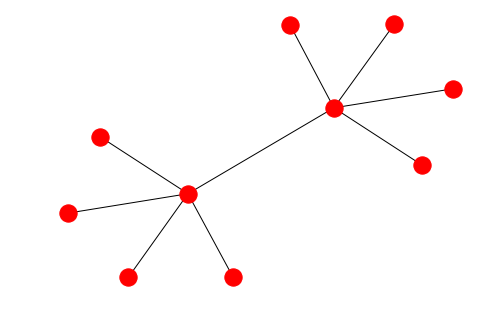

In [55]:
nx.draw(connected_stars(4))

In [100]:
num_v = 500
stars = connected_stars(num_v)
star_centres = [[str(num_v)], [str(2 * num_v + 1)]]
star_ends = [[str(i) for i in range(num_v)], [str(i) for i in range(num_v + 1, 2 * num_v + 1)]]

_, star_vectors, model = get_embeddings(stars)

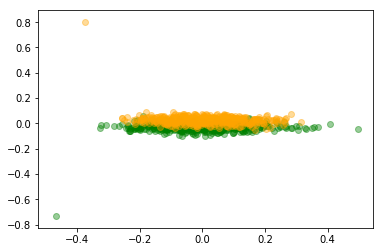

In [102]:
visualize([(star_centres[0], 'green', False), (star_ends[0], 'green', False),
           (star_centres[1], 'orange', False), (star_ends[1], 'orange', False)

          ], star_vectors, plt.figure().gca(), embed_svd)

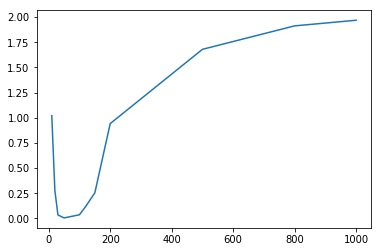

In [127]:
dists = []
nums = [10, 20, 30, 50, 100, 120, 150, 200, 500, 800, 1000]
for num_v in nums:    
    stars = connected_stars(num_v)
    star_centres = [[str(num_v)], [str(2 * num_v + 1)]]
    star_ends = [[str(i) for i in range(num_v)], [str(i) for i in range(num_v + 1, 2 * num_v + 1)]]

    _, star_vectors, model = get_embeddings(stars)
    
    mean_d = 0.0
    for i in range(num_v):
        mean_d += cosine((star_vectors[star_centres[0]] - star_vectors[star_ends[0][i]]).T, \
        (star_vectors[star_centres[1]] - star_vectors[star_ends[1][i]]).T)

    mean_d /= num_v
    dists.append(mean_d)
    
plt.plot(nums, dists)

In [41]:
mean_dist(['0'], ends, star_vectors), inner_mean_dist(ends, star_vectors)

/home/roman/.local/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


(0.049993568169091174, 0.003830249938000355)